# 强化学习之多臂赌博机


一台赌博机有多个摇臂，每个摇臂摇出的奖励
（reward）大小不确定，玩家希望摇固定次数的
臂所获得的期望累积奖励最大

In [70]:
import numpy as np
from numpy import random
from collections import Counter
from math import sqrt, log as ln

c++stl upper_bound

In [39]:
from utils import upper_bound

In [3]:
import scipy.sparse.linalg as linalg
import scipy.sparse as sparse
#import scipy
import matplotlib.pyplot as plt
import os
import pandas as pd
plt.rcParams['font.sans-serif']=['SimHei'] ###用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False ###用来正常显示负号

做数组的前n项和，若是概率分布则转为概率分布函数，增函数，最后一项为1，可以二分查找

In [4]:
def listSum (x):
    rst = []
    for i in x:
        rst += [i + (rst[-1] if rst else 0)]
    return rst

从概率分布中随机选择一个事件发生。
rand为[0,1)，不会越界

In [43]:
def randomChoose(*ps):
    ps = listSum(ps)
    return upper_bound(ps, random.rand())

softmax生成概率

In [19]:
def softmax(*xs):
    xs = np.exp(xs)
    return [* xs / sum(xs)]

测试策略的执行epoch次的性能，绘出平均收益的变化

In [6]:
def testAndDraw (epoch, *stgs, region = None):
    plt.figure(figsize=(10, 5))
    rst = []
    for i, stg in enumerate(stgs):
        scores = []
        rewards = []
        actions = []
        for j in range(epoch):
            reward, action = stg()
            scores += [stg.avgScore()]
            rewards += [reward]
            actions += [action]
        plt.plot(range(epoch), scores, label = 'stg%d.scores' % i)
        #plt.plot(range(epoch), rewards, label = 'reward')
        #plt.plot(range(epoch), actions, label = 'actions')
        plt.legend()
        rst += [(scores, rewards, actions)]
    if region:
        plt.ylim(region)
    return rst

多臂赌博机，n个摇臂，每个摇臂以高斯分布生成收益

In [7]:
class Bandit:
    def __init__ (self, n, EXs, DXs):
        self.n = n
        self.EXs = EXs
        self.DXs = DXs
    def __call__ (self, i):
        return random.normal(self.EXs[i], self.DXs[i])

一个用来测试的多臂赌博机，3个臂i.e.策略有3个action

In [8]:
bandit = Bandit(n=3, EXs = [1, 2, 3], DXs = [1, 1, 1])

多臂赌博机策略类，初始化队对应的多臂赌博机、当前时间i.e.赌博次数，每次调用都会以某个策略选择一个action并进行赌博

子类需要实现chooseAct和update

In [9]:
class BanditStg:
    def __init__ (self, bandit):
        self.t = 0
        self.bandit = bandit
        self.score = 0
        self.numAct = bandit.n
    def __call__ (self):
        action = self.chooseAct ()
        reward = self.bandit(action)
        self.score += reward
        self.t += 1
        self.update(reward, action)
        return reward, action
    def avgScore (self):
        return self.score / self.t if self.t else 0

ε-Greedy策略，以ε的概率explore，(1-ε)的概率exploit i.e.贪心

需要记录每个action i的被选择次数和平均收益，记录为(平均收益,选择次数,i)，每次得到reward之后更新之

Greedy策略只需要令ε为0

In [10]:
class EpsGreedy(BanditStg):
    def __init__ (self, bandit, eps):
        BanditStg.__init__(self, bandit)
        #super(EpsGreedy, self).__init__(bandit)
        self.eps = eps
        self.qs = [(0, 0, i) for i in range(self.numAct)]
    def chooseAct(self):
        if randomChoose(1 - self.eps, self.eps) == 0:
            return max(self.qs)[-1]
        else:
            return randomChoose(*[1 / self.numAct] * self.numAct)
    def update(self, reward, action):
        qOld, n, _ = self.qs[action]
        n += 1
        self.qs[action] = (qOld + (reward - qOld) / n, n, action)

乐观初值法Optimistic Initial Values，为每个行为赋一个高的初始估值的贪心策略

能够在前期迅速explore各个行为

Greedy策略只需要令初值为0

In [11]:
class OptiInitVal(BanditStg):
    def __init__ (self, bandit, initVal):
        BanditStg.__init__(self, bandit)
        self.qs = [(initVal, 0, i) for i in range(self.numAct)]
    def chooseAct(self):
        return max(self.qs)[-1]
    def update(self, reward, action):
        qOld, n, _ = self.qs[action]
        n += 1
        self.qs[action] = (qOld + (reward - qOld) / n, n, action)

梯度赌博机算法

需要记录h，当前对各action的偏好程度，用softmax计算各action的概率$\pi_t(a)$

h更新公式：
$$
\begin{equation}  
\left\{  
             \begin{array}{**lr**}  
             h_{t+1}(a_t) \doteq h_t(a_t) + \alpha(r_t-\bar{r_t})(1-\pi_t(a_t)), &  \\  
             h_{t+1}(a) \doteq h_t(a) - \alpha(r_t-\bar{r_t})\pi_t(a), & for \  all \ a \ne a_t.\\    
             \end{array}  
\right.  
\end{equation} 
$$

question:这里的步长$\alpha$如何选取！！（暂时取为总次数的倒数，但效果并不好！！）

In [64]:
class GradientBandit(BanditStg):
    def __init__ (self, bandit):
        BanditStg.__init__(self, bandit)
        self.hs = [0] * self.numAct
        self.ps = None
        
    def chooseAct (self):
        self.ps = softmax(*self.hs)
        return randomChoose(*self.ps)
    def update (self, reward, action):
        for i in range(self.numAct):
            if i == action:
                self.hs[i] += (1 / self.t) * (reward - self.avgScore()) * (1 - self.ps[i])
            else:
                self.hs[i] -= (1 / self.t) * (reward - self.avgScore()) * self.ps[i]

UCB行为策略选择（Upper Confidence Bound），号称最强

action以此法选择：
$$
a_t \doteq \arg \max_a \left[ q_t(a) + c \sqrt{\frac{\ln t}{n_t(a)}}\right]
$$
其中$n_t(a)$为$a$被选择的次数，$c$用来控制exploration的程度

选择潜力大的行为：依据估值的置信上界进行行为选择

第一项表示当前估值要高，e.g., 接近greedy action

第二项表示不确定性要高，e.g., 被选择的次数少

因此qs记录$(qt+c\sqrt{\frac{\ln t}{n_t}}, qt, n_t, a)$

Greedy策略只需要$c$为0

In [74]:
class UCB(BanditStg):
    def __init__ (self, bandit, c):
        BanditStg.__init__(self, bandit)
        self.c = c
        self.qs = [(0, 0, 0, i) for i in range(self.numAct)]
    def chooseAct(self):
        return max(self.qs)[-1]
    def update(self, reward, action):
        _, qOld, n, _ = self.qs[action]
        n += 1
        self.qs[action] = (0, qOld + (reward - qOld) / n, n, action)
        
        for i in range(self.numAct):
            _, q, n, _ = self.qs[i]
            self.qs[i] = (0 if n == 0 else q + self.c * ln(self.t / n), q, n, i)

三个纯贪心策略，赌博机的随机性

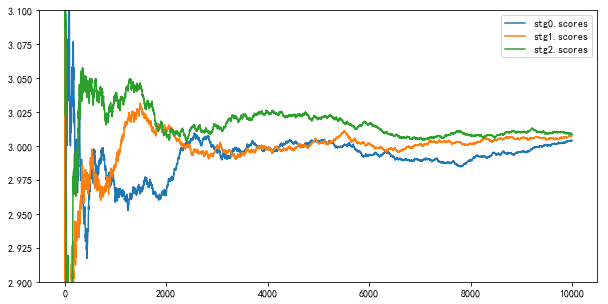

In [37]:
testAndDraw(10000, EpsGreedy(bandit, 0), EpsGreedy(bandit, 0), EpsGreedy(bandit, 0), region=(2.9,3.1));

ε-Greedy的收益，符合计算得到的期望收益

(Counter({2: 9925, 1: 38, 0: 37}),
 Counter({2: 9345, 1: 339, 0: 316}),
 2.979581565153951,
 2.9899999999999998,
 2.9165727016192413,
 2.9000000000000004)

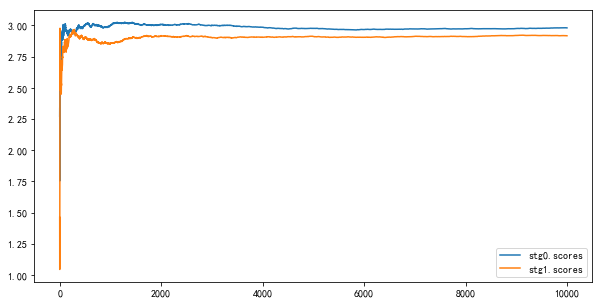

In [72]:
[(s, r, a), (ss, rr, aa)] = testAndDraw(10000, EpsGreedy(bandit, 0.01), EpsGreedy(bandit, 0.1))
Counter(a), Counter(aa), s[-1], 0.99 * 3 + 0.01 * 2,  ss[-1], 0.9 * 3 + 0.1 * 2

ε-Greedy与乐观初值的对比

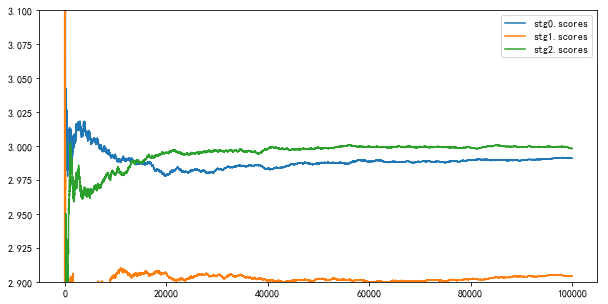

In [99]:
testAndDraw(100000, EpsGreedy(bandit, 0.01), EpsGreedy(bandit, 0.1), OptiInitVal(bandit, 100), region=(2.9,3.1));

梯度赌博机算法，效果不好，可能是步长$\alpha$不对

(2.8737048389635502,
 [0.025279332389001163, 0.05476707221690317, 0.9199535953940957],
 [-1.4558125806641111, -0.6827104798238357, 2.138523060487905])

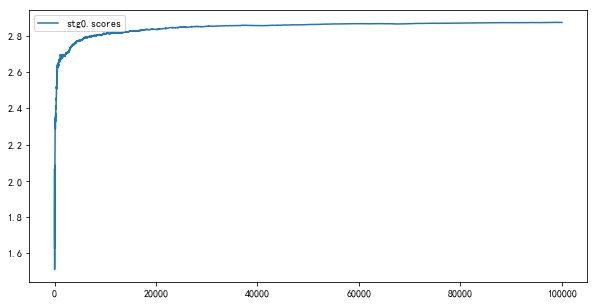

In [63]:
gb = GradientBandit(bandit)
[(s, r, a)] = testAndDraw(100000, gb);
s[-1], gb.ps, gb.hs

对比不同c i.e. exploration程度的UCB

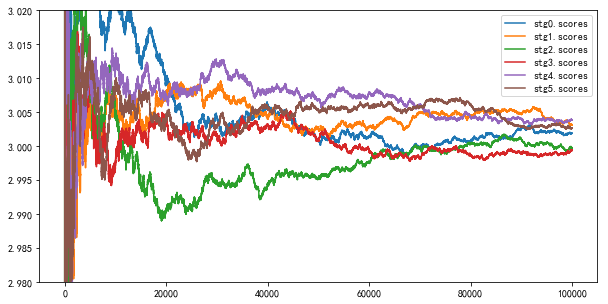

In [81]:
testAndDraw(100000, UCB(bandit, 0), UCB(bandit, 0.2), UCB(bandit, 0.5),
            UCB(bandit, 1), UCB(bandit, 1.5), UCB(bandit, 2), region=(2.98,3.02));

对比ε-Greedy、乐观初值、UCB

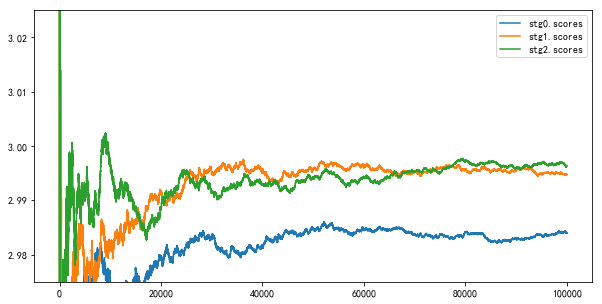

In [88]:
testAndDraw(100000, EpsGreedy(bandit, 0.01), OptiInitVal(bandit, 100), UCB(bandit, 1), region=(2.975,3.025));